# Disney Reviews: Loading and Preprocessing

This notebook demonstrates how to load and preprocess the Disney reviews dataset using `src/data_loader.py`.

It will:
- Load the CSV from the provided ZIP archive.
- Handle missing values.
- Clean and tokenize review text.
- Parse the `Year_Month` column into a standard datetime and extract `Year` and `Month`.
- Encode categorical variables (`Branch`, `Reviewer_Location`) into integer codes.
- Provide a dataset summary.

### Setup and imports

- Adds the project root (`..`) to `sys.path` so the `src/` package (e.g., [src/data_loader.py](cci:7://file:///Users/epam/Downloads/2llm-home-assignment/src/data_loader.py:0:0-0:0)) can be imported when running the notebook from `notebooks/`.
- Imports `pandas` and the main entry point [load_and_preprocess()](cci:1://file:///Users/epam/Downloads/2llm-home-assignment/src/data_loader.py:212:0-238:39) from `src.data_loader`.
- Prints the Pandas version and current working directory for reproducibility and quick environment checks.

In [1]:
# If running from the `notebooks/` directory, add parent to Python path so `src/` is importable
import os, sys
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
from src.data_loader import load_and_preprocess

print('Pandas version:', pd.__version__)
print('Working directory:', os.getcwd())

Pandas version: 2.2.2
Working directory: /Users/epam/Downloads/2llm-home-assignment/notebooks


### Load and preprocess dataset

- Calls [load_and_preprocess('../disney-reviews.zip')](cci:1://file:///Users/epam/Downloads/2llm-home-assignment/src/data_loader.py:212:0-238:39) to:
  - Read the CSV inside the ZIP with robust encoding fallbacks.
  - Handle missing values (median-impute `Rating`, fill unknowns for `Reviewer_Location` and `Branch`, empty string for `Review_Text`).
  - Clean review text (lowercase, remove special characters) and tokenize.
  - Parse `Year_Month` into a `Review_Date` (first day of the month) and add `Year` and `Month`.
  - Encode `Branch` and `Reviewer_Location` into integer codes.
- Returns:
  - `df`: processed DataFrame with additional columns.
  - `mappings`: dictionaries mapping category → integer code.
  - `summary`: basic dataset summary (reviews count, unique parks, unique countries).
- Displays the `summary` for a quick overview.

In [2]:
# Load and preprocess the dataset from the ZIP archive.
# The ZIP lives in the project root, so from notebooks/ we refer to it via '../disney-reviews.zip'
df, mappings, summary = load_and_preprocess(zip_path='../disney-reviews.zip')
summary

{'n_reviews': 42656, 'n_unique_parks': 3, 'n_unique_countries': 162}

### Inspect key processed columns

- Selects a subset of columns to verify preprocessing outputs:
  - Core inputs: `Review_ID`, `Rating`, `Year_Month`, `Reviewer_Location`, `Branch`.
  - Text features: `Cleaned_Review_Text`.
  - Date features: `Year`, `Month`.
  - Encodings: `Branch_Code`, `Reviewer_Location_Code`.
- Uses `head(5)` to preview the first few rows and sanity-check formatting and encodings.

In [3]:
# Inspect a few processed columns
cols = ['Review_ID','Rating','Year_Month','Reviewer_Location','Branch',
        'Cleaned_Review_Text','Year','Month','Branch_Code','Reviewer_Location_Code']
df[cols].head(5)

,Review_ID,Rating,Year_Month,Reviewer_Location,Branch,Cleaned_Review_Text,Year,Month,Branch_Code,Reviewer_Location_Code
0,670772142,4,2019-4,Australia,Disneyland_HongKong,if you ve ever been to disneyland anywhere you...,2019.0,4.0,1,8
1,670682799,4,2019-5,Philippines,Disneyland_HongKong,its been a while since d last time we visit hk...,2019.0,5.0,1,114
2,670623270,4,2019-4,United Arab Emirates,Disneyland_HongKong,thanks god it wasn t too hot or too humid when...,2019.0,4.0,1,151
3,670607911,4,2019-4,Australia,Disneyland_HongKong,hk disneyland is a great compact park unfortun...,2019.0,4.0,1,8
4,670607296,4,2019-4,United Kingdom,Disneyland_HongKong,the location is not in the city took around 1 ...,2019.0,4.0,1,152


### Quick checks and mapping samples

- Computes:
  - `n_parks`: number of unique park branches in `Branch`.
  - `n_countries`: number of unique reviewer locations in `Reviewer_Location`.
- Prints both counts to validate categorical diversity.
- Shows small samples from the returned `mappings`:
  - `branch_mapping`: maps each park (e.g., `Disneyland_HongKong`) to its integer code `Branch_Code`.
  - `reviewer_location_mapping`: maps each reviewer location (country/region) to its integer code `Reviewer_Location_Code`.
- Use these mappings to interpret encoded columns or for consistent encoding across training/inference.

In [4]:
# Quick checks: unique parks and countries based on processed data
n_parks = df['Branch'].nunique(dropna=False)
n_countries = df['Reviewer_Location'].nunique(dropna=False)
print('Unique parks:', n_parks)
print('Unique countries:', n_countries)

# Show the first 10 mapping entries for reference
print('Branch mapping (sample):', dict(list(mappings.branch_mapping.items())[:10]))
print('Reviewer location mapping (sample):', dict(list(mappings.reviewer_location_mapping.items())[:10]))

Unique parks: 3
Unique countries: 162
Branch mapping (sample): {'Disneyland_California': 0, 'Disneyland_HongKong': 1, 'Disneyland_Paris': 2}
Reviewer location mapping (sample): {'Afghanistan': 0, 'Albania': 1, 'Algeria': 2, 'Andorra': 3, 'Antigua and Barbuda': 4, 'Argentina': 5, 'Armenia': 6, 'Aruba': 7, 'Australia': 8, 'Austria': 9}


## Notes
- `Cleaned_Review_Text` is lowercased and stripped of non-alphanumeric characters.
- `Review_Tokens` contains a simple whitespace tokenization of the cleaned text.
- `Review_Date` is the first day of the month parsed from `Year_Month`; unparsable rows are `NaT`.
- `Branch_Code` and `Reviewer_Location_Code` are integer encodings; their mappings are returned by the loader.

### Sentiment analysis setup

- Import sentiment utilities from [src/sentiment_analyzer.py](cci:7://file:///Users/epam/Downloads/2llm-home-assignment/src/sentiment_analyzer.py:0:0-0:0):
  - [add_sentiment()](cci:1://file:///Users/epam/Downloads/2llm-home-assignment/src/sentiment_analyzer.py:52:0-79:14) to compute VADER compound scores and labels.
  - [summarize_by_park()](cci:1://file:///Users/epam/Downloads/2llm-home-assignment/src/sentiment_analyzer.py:111:0-117:69) to aggregate sentiment per `Branch`.
  - [summarize_by_country()](cci:1://file:///Users/epam/Downloads/2llm-home-assignment/src/sentiment_analyzer.py:120:0-126:72) to aggregate sentiment per `Reviewer_Location`.
- Note: If you haven’t installed dependencies, run `pip install -r ../requirements.txt` in a terminal. This includes `vaderSentiment`.

In [5]:
from src.sentiment_analyzer import add_sentiment, summarize_by_park, summarize_by_country

### Add sentiment labels

- Applies VADER sentiment to the cleaned text column `Cleaned_Review_Text`.
- Adds:
  - `Sentiment_Score`: VADER compound score in [-1, 1].
  - `Sentiment_Label`: one of `negative`, `neutral`, `positive`.
- Displays the overall distribution of labels (counts and percentages) to verify output.
- If the package `vaderSentiment` is missing, install dependencies via: `pip install -r ../requirements.txt`.

In [6]:
# If tqdm is missing: pip install tqdm
from tqdm.auto import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from src.data_loader import clean_text  # reuse the same cleaner used in preprocessing

# Ensure we have a cleaned text column
text_col = "Cleaned_Review_Text"
if text_col not in df.columns:
    df[text_col] = df["Review_Text"].fillna("").map(clean_text)

texts = df[text_col].fillna("").astype(str).tolist()
analyzer = SentimentIntensityAnalyzer()

# Compute scores with a progress bar
scores = []
for t in tqdm(texts, desc="Scoring sentiment", unit="review", total=len(texts)):
    scores.append(analyzer.polarity_scores(t)["compound"])

def to_label(compound: float) -> str:
    if compound >= 0.05:
        return "positive"
    if compound <= -0.05:
        return "negative"
    return "neutral"

# Assemble the output DataFrame (same columns as add_sentiment)
df_sent = df.copy()
df_sent["Sentiment_Score"] = scores
df_sent["Sentiment_Label"] = [to_label(c) for c in scores]

# Overall sentiment distribution (counts and percentages)
overall_counts = df_sent["Sentiment_Label"].value_counts(dropna=False)
overall_pct = (overall_counts / overall_counts.sum()).round(3)
overall_distribution = overall_counts.to_frame(name="count").assign(pct=overall_pct)
overall_distribution

/Users/epam/Downloads/2llm-home-assignment/3llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Scoring sentiment: 100%|██████████| 42656/42656 [01:08<00:00, 619.40review/s] 


,count,pct
Sentiment_Label,,
positive,37946,0.890
negative,3926,0.092
neutral,784,0.018


### Sentiment distribution by park (Branch)

- Aggregates sentiment counts and percentages for each park (`Branch`).
- Sorted by total number of reviews to surface the most represented park(s).

In [7]:
by_park = summarize_by_park(df_sent, label_col="Sentiment_Label", park_col="Branch")

# Display sorted by total reviews
by_park_sorted = by_park.sort_values("total", ascending=False).reset_index(drop=True)

# Optional: round percentage columns for readability
pct_cols = ["negative_pct", "neutral_pct", "positive_pct"]
by_park_sorted[pct_cols] = by_park_sorted[pct_cols].round(3)

by_park_sorted

Sentiment_Label,Branch,negative,neutral,positive,total,negative_pct,neutral_pct,positive_pct
0,Disneyland_California,1591,371,17444,19406,0.082,0.019,0.899
1,Disneyland_Paris,1671,223,11736,13630,0.123,0.016,0.861
2,Disneyland_HongKong,664,190,8766,9620,0.069,0.020,0.911


### Sentiment distribution by country (Reviewer_Location)

- Aggregates sentiment counts and percentages per reviewer country/location.
- Shows the top 20 countries by total reviews.

In [8]:
by_country = summarize_by_country(df_sent, label_col="Sentiment_Label", country_col="Reviewer_Location")

# Show top 20 countries by total reviews
by_country_top20 = by_country.sort_values("total", ascending=False).head(20).reset_index(drop=True)

# Optional: round percentage columns for readability
pct_cols = ["negative_pct", "neutral_pct", "positive_pct"]
by_country_top20[pct_cols] = by_country_top20[pct_cols].round(3)

by_country_top20

Sentiment_Label,Reviewer_Location,negative,neutral,positive,total,negative_pct,neutral_pct,positive_pct
0,United States,1275,285,12991,14551,0.088,0.020,0.893
1,United Kingdom,1146,174,8431,9751,0.118,0.018,0.865
2,Australia,327,57,4295,4679,0.070,0.012,0.918
3,Canada,199,57,1979,2235,0.089,0.026,0.885
4,India,86,31,1394,1511,0.057,0.021,0.923
5,Philippines,63,13,994,1070,0.059,0.012,0.929
6,Singapore,108,27,902,1037,0.104,0.026,0.870
7,New Zealand,50,6,700,756,0.066,0.008,0.926
8,Malaysia,38,19,531,588,0.065,0.032,0.903
9,Hong Kong,68,14,472,554,0.123,0.025,0.852


### Optional: Quick bar charts for sentiment by park and country

- Visualize counts by sentiment per park/country using stacked bars.
- Adjust figure size or limit to top-N categories for readability.

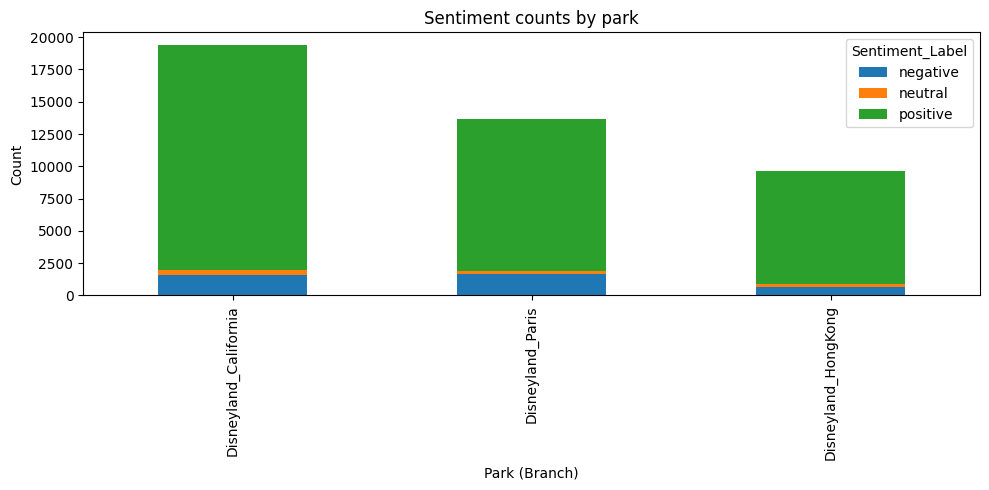

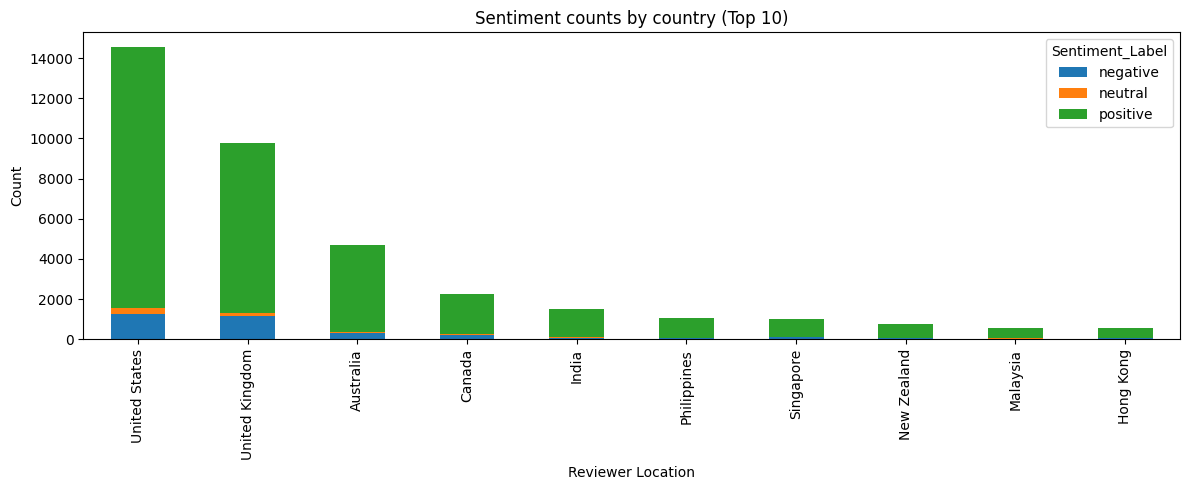

In [9]:
import matplotlib.pyplot as plt

# Park-level stacked bar chart (counts)
plot_cols = ["negative", "neutral", "positive"]
by_park_plot = by_park_sorted.set_index("Branch")[plot_cols]

ax = by_park_plot.plot(kind="bar", stacked=True, figsize=(10, 5), title="Sentiment counts by park")
ax.set_xlabel("Park (Branch)")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

# Country-level stacked bar chart (top 10 by total)
top10_countries = by_country.sort_values("total", ascending=False).head(10)
by_country_plot = top10_countries.set_index("Reviewer_Location")[plot_cols]

ax = by_country_plot.plot(kind="bar", stacked=True, figsize=(12, 5), title="Sentiment counts by country (Top 10)")
ax.set_xlabel("Reviewer Location")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

### Insights setup

- Imports insight utilities from [src/insights.py](cci:7://file:///Users/epam/Downloads/2llm-home-assignment/src/insights.py:0:0-0:0):
  - [busiest_months_by_park()](cci:1://file:///Users/epam/Downloads/2llm-home-assignment/src/insights.py:32:0-54:94) to rank months by review volume per park.
  - [sentiment_extremes_by_park()](cci:1://file:///Users/epam/Downloads/2llm-home-assignment/src/insights.py:73:0-103:5) to find which parks receive the most positive and most negative reviews.
  - [temporal_trends()](cci:1://file:///Users/epam/Downloads/2llm-home-assignment/src/insights.py:106:0-169:106) to detect improving/declining/stable patterns over time (ratings and positive-rate).
  - [build_structured_summary()](cci:1://file:///Users/epam/Downloads/2llm-home-assignment/src/insights.py:172:0-182:5) to gather all insights into a single structure.
  - [generate_llm_recommendations()](cci:1://file:///Users/epam/Downloads/2llm-home-assignment/src/insights.py:247:4-250:9) to create concise, actionable recommendations with an LLM (uses `gpt-4o-mini` and reads `OPENAI_API_KEY` from [.env](cci:7://file:///Users/epam/Downloads/2llm-home-assignment/.env:0:0-0:0)).
- Note: If you haven’t installed dependencies, run `pip install -r ../requirements.txt` in a terminal.

In [10]:
from src.insights import (
    busiest_months_by_park,
    sentiment_extremes_by_park,
    temporal_trends,
    build_structured_summary,
    generate_llm_recommendations,
)

### Busiest months by park

- Computes monthly review counts per park.
- Ranks months within each park to identify the busiest periods.
- Shows the busiest month per park and a top-3 view for more context.

In [11]:
busy = busiest_months_by_park(df_sent)

# Busiest (rank 1) month(s) per park
busiest_top1 = busy.loc[busy["Rank_in_Park"] == 1].sort_values(["Branch", "Year", "Month"]).reset_index(drop=True)

# Top 3 busiest months per park for additional context
busiest_top3 = busy.loc[busy["Rank_in_Park"] <= 3].sort_values(["Branch", "Rank_in_Park", "Year", "Month"]).reset_index(drop=True)

print("Busiest month per park:")
display(busiest_top1)

print("\nTop 3 busiest months per park:")
display(busiest_top3)

Busiest month per park:


,Branch,Year,Month,Review_Count,Month_Name,Rank_in_Park
0,Disneyland_California,2015,7,351,Jul,1
1,Disneyland_HongKong,2015,12,249,Dec,1
2,Disneyland_Paris,2015,8,331,Aug,1



Top 3 busiest months per park:


,Branch,Year,Month,Review_Count,Month_Name,Rank_in_Park
0,Disneyland_California,2015,7,351,Jul,1
1,Disneyland_California,2015,6,343,Jun,2
2,Disneyland_California,2015,8,343,Aug,2
3,Disneyland_California,2015,5,325,May,3
4,Disneyland_HongKong,2015,12,249,Dec,1
5,Disneyland_HongKong,2016,12,183,Dec,2
6,Disneyland_HongKong,2015,11,180,Nov,3
7,Disneyland_Paris,2015,8,331,Aug,1
8,Disneyland_Paris,2015,7,278,Jul,2
9,Disneyland_Paris,2014,8,244,Aug,3


In [12]:
# pip install matplotlib


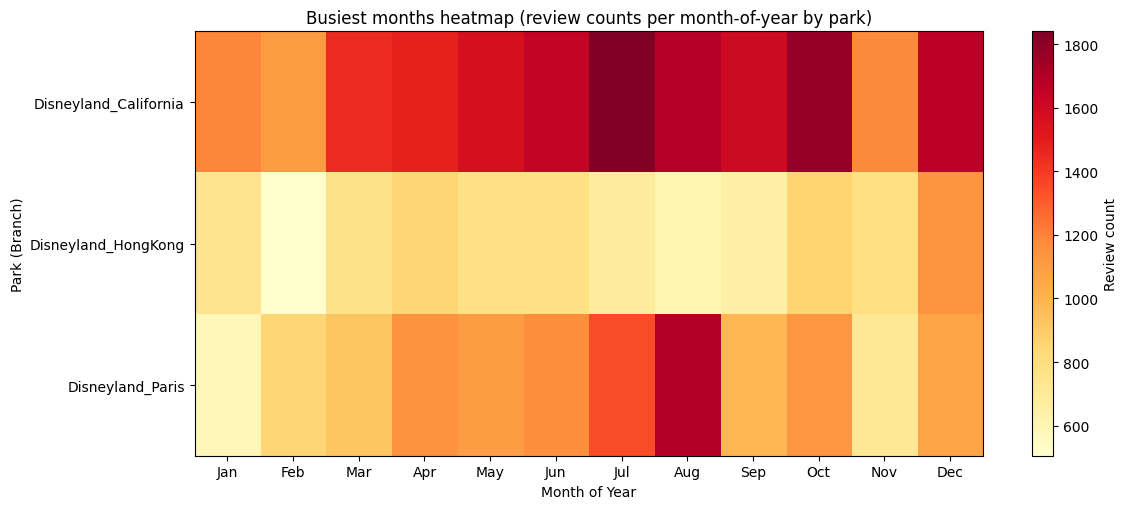

In [13]:
import matplotlib.pyplot as plt  # Add this import

# existing code below

# Aggregate by month-of-year across all years
tmp = df_sent.dropna(subset=["Review_Date"]).copy()
tmp["month"] = tmp["Review_Date"].dt.month

heat = tmp.groupby(["Branch", "month"]).size().unstack(fill_value=0)
# Ensure months are in 1..12 order
heat = heat.reindex(columns=range(1, 12+1), fill_value=0)

# Make month labels
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

fig, ax = plt.subplots(figsize=(12, 4 + 0.4*len(heat)))
im = ax.imshow(heat.values, aspect="auto", cmap="YlOrRd")

# Tick labels
ax.set_yticks(range(len(heat.index)))
ax.set_yticklabels(heat.index)
ax.set_xticks(range(12))
ax.set_xticklabels(month_labels, rotation=0)
ax.set_title("Busiest months heatmap (review counts per month-of-year by park)")
ax.set_xlabel("Month of Year")
ax.set_ylabel("Park (Branch)")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Review count")

plt.tight_layout()
plt.show()

### Parks with the most positive and negative reviews

- Aggregates sentiment by park to identify extremes.
- Returns which park has the highest number of positive reviews and which has the highest number of negative reviews.
- Also provides the full per-park sentiment table.

In [14]:
extremes = sentiment_extremes_by_park(df_sent)

print("Most positive park:")
display(extremes["most_positive"])

print("\nMost negative park:")
display(extremes["most_negative"])

print("\nSentiment summary by park (counts and percentages):")
by_park_sent = extremes["by_park"].copy()

# Helpful sorts
by_park_sent_sorted_total = by_park_sent.sort_values("total", ascending=False).reset_index(drop=True)
by_park_sent_sorted_pospct = by_park_sent.sort_values("positive_pct", ascending=False).reset_index(drop=True)
by_park_sent_sorted_negpct = by_park_sent.sort_values("negative_pct", ascending=False).reset_index(drop=True)

print("\nTop by total reviews:")
display(by_park_sent_sorted_total)

print("\nTop by positive percentage:")
display(by_park_sent_sorted_pospct)

print("\nTop by negative percentage:")
display(by_park_sent_sorted_negpct)

Most positive park:


{'park': 'Disneyland_California',
 'positive_count': 17444,
 'total': 19406,
 'positive_pct': 0.8988972482737297}


Most negative park:


{'park': 'Disneyland_Paris',
 'negative_count': 1671,
 'total': 13630,
 'negative_pct': 0.12259721203228173}


Sentiment summary by park (counts and percentages):

Top by total reviews:


Sentiment_Label,Branch,negative,neutral,positive,total,negative_pct,neutral_pct,positive_pct
0,Disneyland_California,1591,371,17444,19406,0.081985,0.019118,0.898897
1,Disneyland_Paris,1671,223,11736,13630,0.122597,0.016361,0.861042
2,Disneyland_HongKong,664,190,8766,9620,0.069023,0.019751,0.911227



Top by positive percentage:


Sentiment_Label,Branch,negative,neutral,positive,total,negative_pct,neutral_pct,positive_pct
0,Disneyland_HongKong,664,190,8766,9620,0.069023,0.019751,0.911227
1,Disneyland_California,1591,371,17444,19406,0.081985,0.019118,0.898897
2,Disneyland_Paris,1671,223,11736,13630,0.122597,0.016361,0.861042



Top by negative percentage:


Sentiment_Label,Branch,negative,neutral,positive,total,negative_pct,neutral_pct,positive_pct
0,Disneyland_Paris,1671,223,11736,13630,0.122597,0.016361,0.861042
1,Disneyland_California,1591,371,17444,19406,0.081985,0.019118,0.898897
2,Disneyland_HongKong,664,190,8766,9620,0.069023,0.019751,0.911227


### Trends over time (ratings and positive-rate)

- Computes monthly mean rating and positive-rate per park.
- Fits a simple linear trend vs time to classify each park’s trajectory:
  - improving
  - stable
  - declining
- Also reports the number of months used for each park’s trend.

In [15]:
trends = temporal_trends(df_sent, min_points=6, slope_threshold=1e-3)

# Show overall trends per park
display(trends)

# Improving/declining by RATING trend
print("\nImproving parks (by rating):")
display(
    trends.loc[trends["rating_direction"] == "improving"]
           .sort_values("rating_slope", ascending=False)
)

print("\nDeclining parks (by rating):")
display(
    trends.loc[trends["rating_direction"] == "declining"]
           .sort_values("rating_slope", ascending=True)
)

,Branch,rating_slope,rating_direction,positive_rate_slope,positive_rate_direction,n_months
0,Disneyland_California,-0.002913,declining,-0.000310,stable,110
1,Disneyland_HongKong,0.002703,improving,0.000494,stable,107
2,Disneyland_Paris,0.001656,improving,0.000279,stable,109



Improving parks (by rating):


,Branch,rating_slope,rating_direction,positive_rate_slope,positive_rate_direction,n_months
1,Disneyland_HongKong,0.002703,improving,0.000494,stable,107
2,Disneyland_Paris,0.001656,improving,0.000279,stable,109



Declining parks (by rating):


,Branch,rating_slope,rating_direction,positive_rate_slope,positive_rate_direction,n_months
0,Disneyland_California,-0.002913,declining,-0.00031,stable,110


### Optional: classify positive_rate trends with a more sensitive threshold

In [16]:
# Recompute trends with a smaller threshold to classify positive_rate changes
trends_pos = temporal_trends(df_sent, min_points=6, slope_threshold=2e-4)

print("\nImproving parks (by positive rate):")
display(
    trends_pos.loc[trends_pos["positive_rate_direction"] == "improving"]
               .sort_values("positive_rate_slope", ascending=False)
)

print("\nDeclining parks (by positive rate):")
display(
    trends_pos.loc[trends_pos["positive_rate_direction"] == "declining"]
               .sort_values("positive_rate_slope", ascending=True)
)


Improving parks (by positive rate):


,Branch,rating_slope,rating_direction,positive_rate_slope,positive_rate_direction,n_months
1,Disneyland_HongKong,0.002703,improving,0.000494,improving,107
2,Disneyland_Paris,0.001656,improving,0.000279,improving,109



Declining parks (by positive rate):


,Branch,rating_slope,rating_direction,positive_rate_slope,positive_rate_direction,n_months
0,Disneyland_California,-0.002913,declining,-0.00031,declining,110


### Optional: Visualize monthly rating and positive-rate trends

- Plots monthly mean rating and positive-rate per park.
- Useful for sanity checking the trend classification and spotting anomalies.

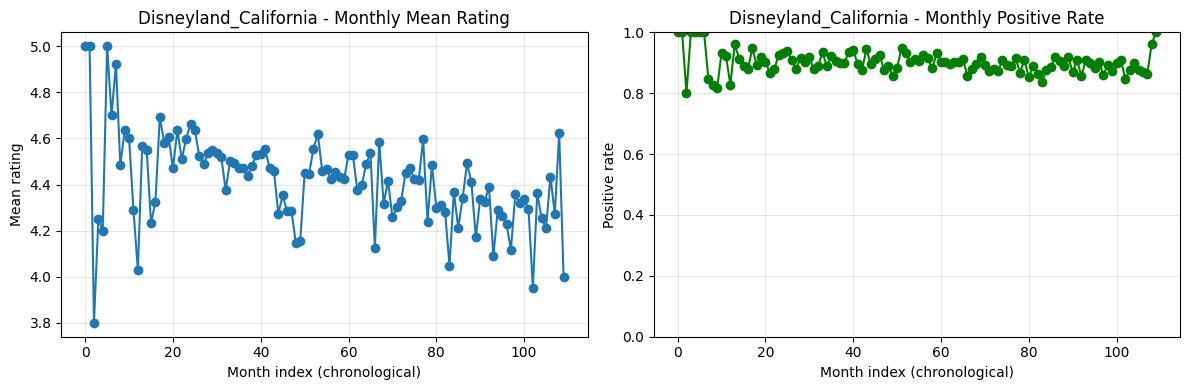

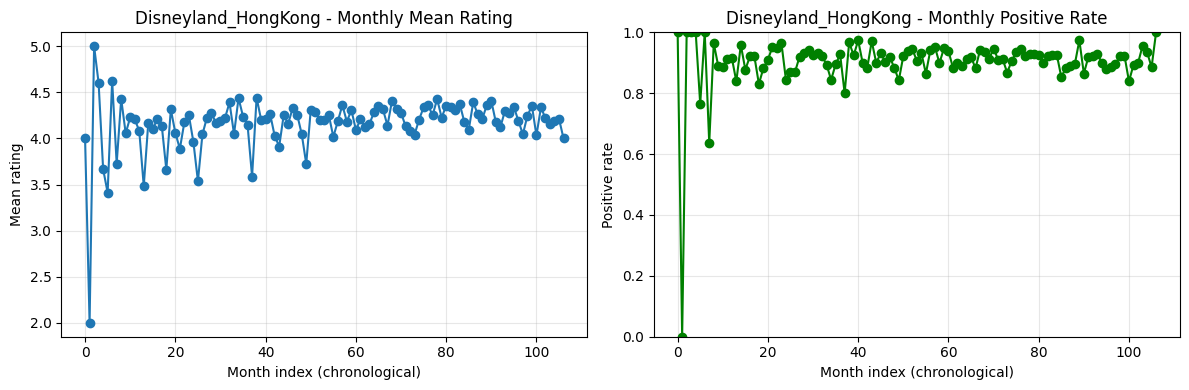

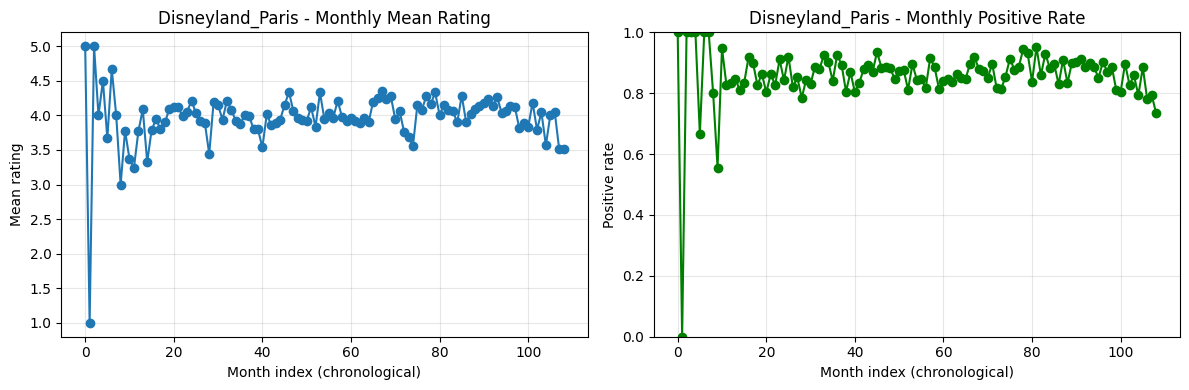

In [17]:
import matplotlib.pyplot as plt

# Prepare monthly aggregates
tmp = df_sent.dropna(subset=["Review_Date"]).copy()
tmp["Year"] = tmp["Review_Date"].dt.year
tmp["Month"] = tmp["Review_Date"].dt.month
tmp["is_positive"] = (tmp["Sentiment_Label"] == "positive").astype(int)

monthly = (
    tmp.groupby(["Branch", "Year", "Month"])
       .agg(mean_rating=("Rating", "mean"),
            positive_rate=("is_positive", "mean"),
            n_reviews=("Rating", "size"))
       .reset_index()
       .sort_values(["Branch", "Year", "Month"])
)

for park, g in monthly.groupby("Branch"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    t = range(len(g))
    ax[0].plot(t, g["mean_rating"], marker="o")
    ax[0].set_title(f"{park} - Monthly Mean Rating")
    ax[0].set_xlabel("Month index (chronological)")
    ax[0].set_ylabel("Mean rating")
    ax[0].grid(True, alpha=0.3)

    ax[1].plot(t, g["positive_rate"], color="green", marker="o")
    ax[1].set_title(f"{park} - Monthly Positive Rate")
    ax[1].set_xlabel("Month index (chronological)")
    ax[1].set_ylabel("Positive rate")
    ax[1].set_ylim(0, 1)
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

#### Temporal trends with 3-month rolling averages (smoother lines)

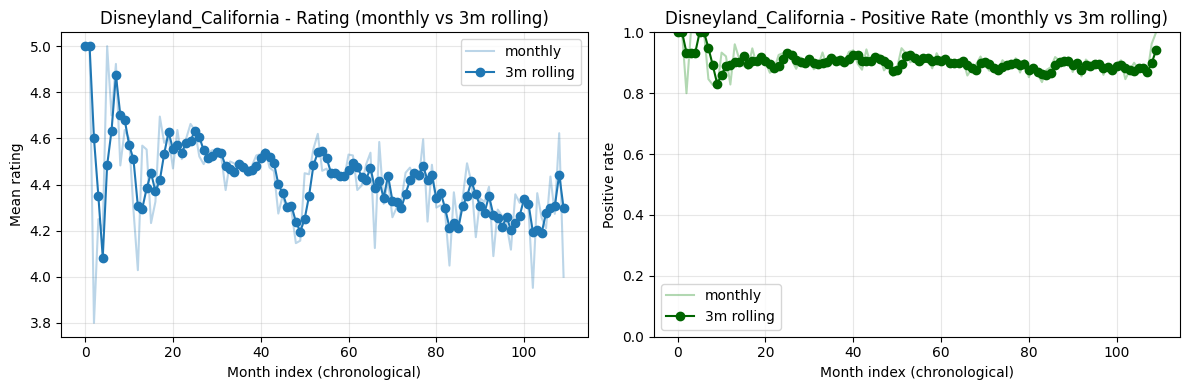

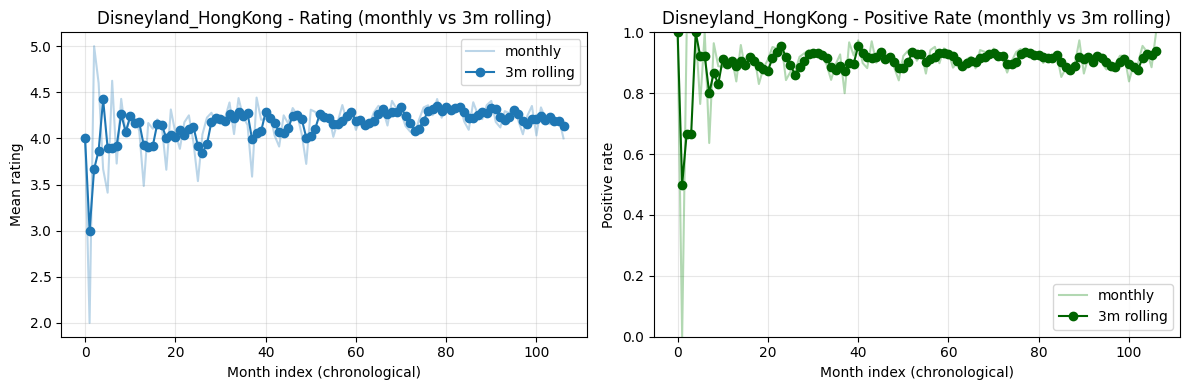

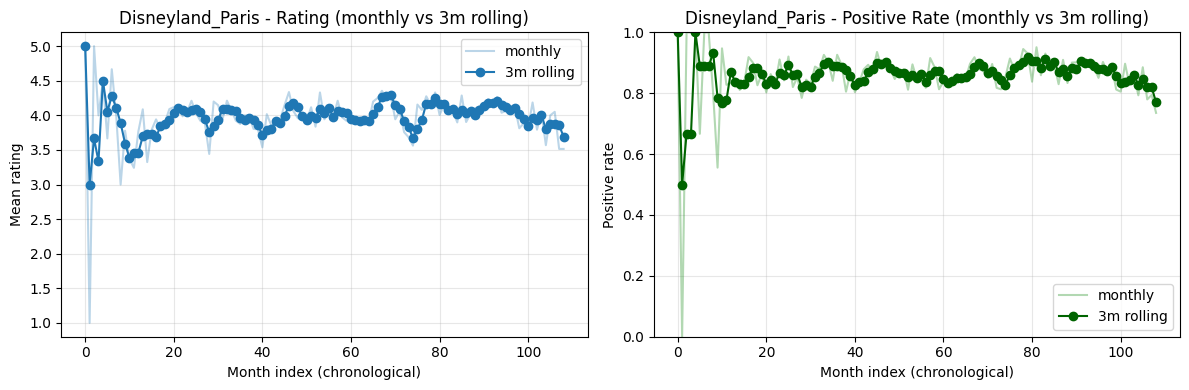

In [18]:
# 3-month rolling average for smoother plots
for park, g in monthly.groupby("Branch"):
    g = g.copy()
    g["mean_rating_3m"] = g["mean_rating"].rolling(3, min_periods=1).mean()
    g["positive_rate_3m"] = g["positive_rate"].rolling(3, min_periods=1).mean()

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    t = range(len(g))
    ax[0].plot(t, g["mean_rating"], alpha=0.3, label="monthly")
    ax[0].plot(t, g["mean_rating_3m"], color="C0", marker="o", label="3m rolling")
    ax[0].set_title(f"{park} - Rating (monthly vs 3m rolling)")
    ax[0].set_xlabel("Month index (chronological)")
    ax[0].set_ylabel("Mean rating")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    ax[1].plot(t, g["positive_rate"], alpha=0.3, color="green", label="monthly")
    ax[1].plot(t, g["positive_rate_3m"], color="darkgreen", marker="o", label="3m rolling")
    ax[1].set_title(f"{park} - Positive Rate (monthly vs 3m rolling)")
    ax[1].set_xlabel("Month index (chronological)")
    ax[1].set_ylabel("Positive rate")
    ax[1].set_ylim(0, 1)
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Trend slopes bar charts (using your trends DataFrame)



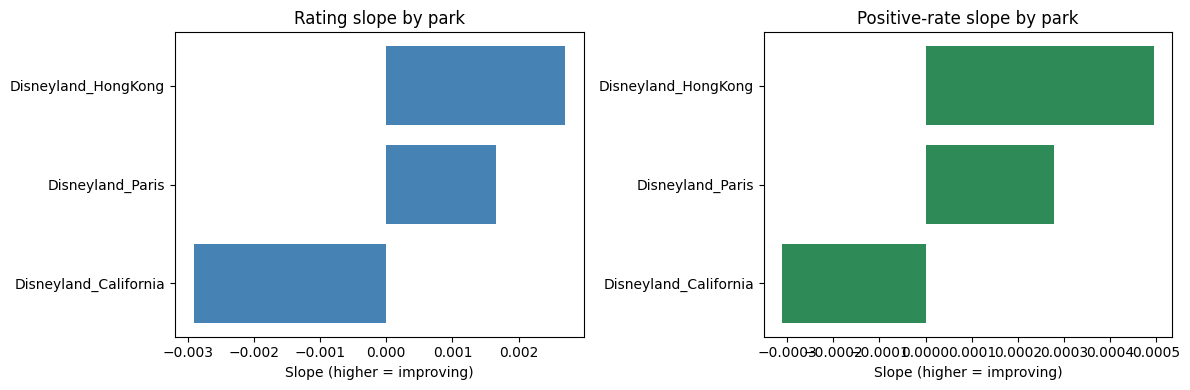

In [19]:
# from src.insights import temporal_trends
# trends = temporal_trends(df_sent, min_points=6, slope_threshold=1e-3)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Rating slope bars
trends_sorted_rating = trends.sort_values("rating_slope", ascending=False)
ax[0].barh(trends_sorted_rating["Branch"], trends_sorted_rating["rating_slope"], color="steelblue")
ax[0].invert_yaxis()
ax[0].set_title("Rating slope by park")
ax[0].set_xlabel("Slope (higher = improving)")

# Positive-rate slope bars
trends_sorted_pos = trends.sort_values("positive_rate_slope", ascending=False)
ax[1].barh(trends_sorted_pos["Branch"], trends_sorted_pos["positive_rate_slope"], color="seagreen")
ax[1].invert_yaxis()
ax[1].set_title("Positive-rate slope by park")
ax[1].set_xlabel("Slope (higher = improving)")

plt.tight_layout()
plt.show()

#### Review length distribution (quick quality check for text)



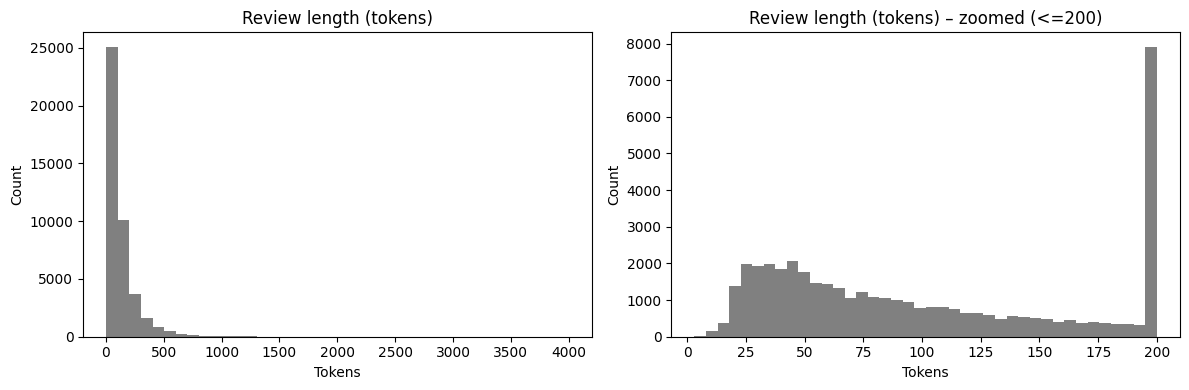

In [20]:
# Distribution of cleaned review lengths (in tokens)
review_lengths = df_sent["Review_Tokens"].map(len)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(review_lengths, bins=40, color="gray")
ax[0].set_title("Review length (tokens)")
ax[0].set_xlabel("Tokens")
ax[0].set_ylabel("Count")

ax[1].hist(review_lengths.clip(upper=200), bins=40, color="gray")
ax[1].set_title("Review length (tokens) – zoomed (<=200)")
ax[1].set_xlabel("Tokens")
ax[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

### Structured summary and LLM-based recommendations

- Builds a structured summary with:
  - Busiest months per park.
  - Sentiment extremes (most positive/negative parks) and per-park sentiment summary.
  - Temporal trends classification.
- Optionally generates 5–8 concise, actionable recommendations using an LLM:
  - Uses `gpt-4o-mini`.
  - Reads `OPENAI_API_KEY` from your environment; [.env](cci:7://file:///Users/epam/Downloads/2llm-home-assignment/.env:0:0-0:0) is supported.
  - If the key is missing or dependencies are not installed, a helpful message will be returned.

In [21]:
import importlib, src.insights as insights
importlib.reload(insights)
from src.insights import generate_llm_recommendations

In [22]:
# Build structured summary
summary = build_structured_summary(df_sent)

# Preview pieces of the summary
print("Busiest months by park (head):")
display(summary["busiest_months_by_park"].head(10))

print("\nSentiment extremes (dict):")
display({k: v for k, v in summary["sentiment_extremes"].items() if k != "by_park"})
print("\nSentiment by park (head):")
display(summary["sentiment_extremes"]["by_park"].head(10))

print("\nTemporal trends (head):")
display(summary["temporal_trends"].head(10))

# Generate LLM recommendations (requires OPENAI_API_KEY in environment)
recs = generate_llm_recommendations(summary, model="gpt-4o-mini", max_tokens=500)
print("\nRecommendations:\n")
print(recs)

Busiest months by park (head):


,Branch,Year,Month,Review_Count,Month_Name,Rank_in_Park
0,Disneyland_California,2015,7,351,Jul,1
1,Disneyland_California,2015,6,343,Jun,2
2,Disneyland_California,2015,8,343,Aug,2
3,Disneyland_California,2015,5,325,May,3
4,Disneyland_California,2015,9,316,Sep,4
5,Disneyland_California,2015,12,294,Dec,5
6,Disneyland_California,2015,10,289,Oct,6
7,Disneyland_California,2014,7,288,Jul,7
8,Disneyland_California,2014,10,285,Oct,8
9,Disneyland_California,2014,9,284,Sep,9



Sentiment extremes (dict):


{'most_positive': {'park': 'Disneyland_California',
  'positive_count': 17444,
  'total': 19406,
  'positive_pct': 0.8988972482737297},
 'most_negative': {'park': 'Disneyland_Paris',
  'negative_count': 1671,
  'total': 13630,
  'negative_pct': 0.12259721203228173}}


Sentiment by park (head):


Sentiment_Label,Branch,negative,neutral,positive,total,negative_pct,neutral_pct,positive_pct
0,Disneyland_California,1591,371,17444,19406,0.081985,0.019118,0.898897
1,Disneyland_HongKong,664,190,8766,9620,0.069023,0.019751,0.911227
2,Disneyland_Paris,1671,223,11736,13630,0.122597,0.016361,0.861042



Temporal trends (head):


,Branch,rating_slope,rating_direction,positive_rate_slope,positive_rate_direction,n_months
0,Disneyland_California,-0.002913,declining,-0.000310,stable,110
1,Disneyland_HongKong,0.002703,improving,0.000494,stable,107
2,Disneyland_Paris,0.001656,improving,0.000279,stable,109



Recommendations:

### Actionable Recommendations for Operations and CX Teams

1. **Staffing Optimization:**
   - Increase staffing levels during peak months (June, July, August) at Disneyland California to enhance guest experience and reduce wait times.
   - Implement flexible staffing models that allow for rapid adjustment based on real-time crowd levels, especially during weekends and holidays.

2. **Amenities Enhancement:**
   - Expand food and beverage options during peak times to accommodate higher guest volumes, focusing on quick-service outlets to reduce wait times.
   - Enhance restroom facilities and ensure they are adequately stocked and maintained, particularly in high-traffic areas during busy months.

3. **Effective Communications:**
   - Develop a proactive communication strategy to inform guests about peak times, wait times, and available amenities via mobile apps and on-site signage.
   - Utilize social media channels to provide real-time updates and engage with guests

### Example recommendation themes

- Staffing and Operations
  - Increase staff availability during the identified peak months for each park to reduce queue times and improve guest support.
- Communications
  - Proactively communicate expected crowds and offer itinerary suggestions ahead of peak periods.
- Amenities and Experience
  - Prioritize maintenance and cleanliness during peak months; expand shaded seating and hydration stations where heat correlates with negative reviews.
- Service Recovery
  - In parks trending downward, deploy roving “guest experience” teams trained to resolve issues on the spot.
- Content and Attractions
  - For parks with the highest negative share, analyze which attraction reviews drive negativity and prioritize targeted improvements or messaging.

### Project paths (pythonic with pathlib)

In [23]:
from pathlib import Path

# Assuming this notebook lives at: project_root/notebooks/
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"

# Make sure folders exist
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Data dir:", DATA_DIR)
print("Processed dir:", PROCESSED_DIR)

Project root: /Users/epam/Downloads/2llm-home-assignment
Data dir: /Users/epam/Downloads/2llm-home-assignment/data
Processed dir: /Users/epam/Downloads/2llm-home-assignment/data/processed


### Persist processed dataset (after load_and_preprocess)

In [24]:
import importlib
from src.data_loader import save_processed_dataset
importlib.reload(__import__("src.data_loader").data_loader)

paths_proc = save_processed_dataset(
    df=df,                               # DataFrame returned by load_and_preprocess
    dir_path=PROCESSED_DIR,              # pathlib.Path is accepted
    base_name="disney_reviews_processed",
    save_csv=True,
    save_parquet=True,                   # requires pyarrow or fastparquet
)
print("Processed saved files:", paths_proc)

Processed saved files: {'csv': '/Users/epam/Downloads/2llm-home-assignment/data/processed/disney_reviews_processed.csv', 'parquet': '/Users/epam/Downloads/2llm-home-assignment/data/processed/disney_reviews_processed.parquet'}


### Persist processed dataset (after load_and_preprocess)
Saves the processed DataFrame `df` to `../data/processed/` as CSV and Parquet (if pyarrow is installed).

In [25]:
# Ensure latest code
import importlib
from src.data_loader import save_processed_dataset
importlib.reload(__import__("src.data_loader").data_loader)

# Save processed dataset (df) to data/processed/
paths_proc = save_processed_dataset(
    df=df,                                  # the DataFrame returned by load_and_preprocess
    dir_path="../data/processed",           # notebooks/ → project root/data/processed
    base_name="disney_reviews_processed",
    save_csv=True,
    save_parquet=True,                      # requires pyarrow or fastparquet
)
print("Processed saved files:", paths_proc)

Processed saved files: {'csv': '../data/processed/disney_reviews_processed.csv', 'parquet': '../data/processed/disney_reviews_processed.parquet'}


### Persist sentiment-enriched dataset (after adding VADER sentiment)

In [26]:
import importlib
from src.data_loader import save_processed_dataset
importlib.reload(__import__("src.data_loader").data_loader)

paths_sent = save_processed_dataset(
    df=df_sent,
    dir_path=PROCESSED_DIR,
    base_name="disney_reviews_with_sentiment",
    save_csv=True,
    save_parquet=True,
)
print("Sentiment-enriched saved files:", paths_sent)

Sentiment-enriched saved files: {'csv': '/Users/epam/Downloads/2llm-home-assignment/data/processed/disney_reviews_with_sentiment.csv', 'parquet': '/Users/epam/Downloads/2llm-home-assignment/data/processed/disney_reviews_with_sentiment.parquet'}


### Fast path: load previously saved dataset (skip recompute if available)

In [27]:
from src.data_loader import load_processed_dataset

sent_parquet = PROCESSED_DIR / "disney_reviews_with_sentiment.parquet"
sent_csv = PROCESSED_DIR / "disney_reviews_with_sentiment.csv"

if sent_parquet.exists():
    df_sent = load_processed_dataset(sent_parquet)
    print("Loaded from Parquet:", sent_parquet)
elif sent_csv.exists():
    df_sent = load_processed_dataset(sent_csv)
    print("Loaded from CSV:", sent_csv)
else:
    print("No saved dataset found. Proceed with full load + preprocessing + sentiment steps.")

Loaded from Parquet: /Users/epam/Downloads/2llm-home-assignment/data/processed/disney_reviews_with_sentiment.parquet


### RAG QA setup

- Uses [src/rag_qa.py](cci:7://file:///Users/epam/Downloads/2llm-home-assignment/src/rag_qa.py:0:0-0:0):
  - [build_faiss_index()](cci:1://file:///Users/epam/Downloads/2llm-home-assignment/src/rag_qa.py:80:0-123:91) to build a FAISS cosine-similarity index on `Cleaned_Review_Text` with OpenAI embeddings.
  - [answer_question()](cci:1://file:///Users/epam/Downloads/2llm-home-assignment/src/rag_qa.py:313:0-379:5) to parse filters (park, country, month/season, year), retrieve relevant reviews, and generate an answer with `gpt-4o-mini`.
- Reads the OpenAI key from your project `.env`. If needed, set `ENV_PATH` explicitly to ensure the key is found from `notebooks/`.
- If you haven’t yet, install dependencies in a terminal: `pip install -r ../requirements.txt`.

### Build index with tqdm progress



In [45]:
# Ensure latest module code is used
import importlib, src.rag_qa as rag_qa
importlib.reload(rag_qa)
from src.rag_qa import build_faiss_index, answer_question

# Dynamic .env path resolution
from dotenv import find_dotenv
ENV_PATH = find_dotenv(usecwd=True) or None
print("Resolved ENV_PATH:", ENV_PATH or "<not found>")

# Build the index over cleaned review texts
# prefer_backend="faiss" to use the FAISS backend (since you installed faiss-cpu),
# or "auto" to fall back to NumPy if FAISS isn’t available.
rag = build_faiss_index(
    df_sent,                             # preprocessed + sentiment DataFrame
    text_col="Cleaned_Review_Text",
    env_path=ENV_PATH,                   # reads OPENAI_API_KEY or OPEN_AI_KEY
    embedding_model="text-embedding-3-small",
    prefer_backend="faiss",
    batch_size=100,
    show_progress=True,                  # <- enables tqdm during embeddings
)
print("Backend:", rag.backend)
print("Dimension:", rag.dim)
print("Vectors:", len(rag.id2meta))

Resolved ENV_PATH: /Users/epam/Downloads/2llm-home-assignment/.env


Embedding reviews: 100%|██████████| 427/427 [10:39<00:00,  1.50s/batch]


Backend: faiss
Dimension: 1536
Vectors: 42656


### Ask a question (FAISS retrieval)

In [57]:
from src.rag_qa import answer_question

def ask(q, top_k=12, model="gpt-4o-mini"):
    res = answer_question(
        question=q,
        rag=rag,
        df=df_sent,
        env_path=ENV_PATH,
        model=model,
        top_k=top_k,
    )
    print("\n\nQuestion:", q)
    print("Filters:", res["filters"])
    print("Stats summary:", res["stats_summary"])
    print("\nAnswer:\n", res["answer"])
    return res

# Examples requested
res1 = ask("What do visitors from Australia say about Disneyland in Hong Kong?")
res2 = ask("Is spring a good time to visit Disneyland?")
res3 = ask("Is the staff in Paris friendly?")
res4 = ask("Is Disneyland California usually crowded in June?")



Question: What do visitors from Australia say about Disneyland in Hong Kong?
Filters: {'topics': [], 'country': 'Australia'}
Stats summary: Records: 4679 | Sentiment: +4295 / 57 / -327 (total 4679) | Avg rating: 4.31 | Top months: 2015-09 (111), 2014-09 (93), 2016-01 (91)

Answer:
 ## Filters
Active filters: country = Australia

## Stats Summary
Records: 4679 | Sentiment: +4295 / 57 / -327 (total 4679) | Avg rating: 4.31 | Top months: 2015-09 (111), 2014-09 (93), 2016-01 (91)

## Insights
- The sentiment from Australian visitors is predominantly positive, with a high average rating of 4.31, indicating a generally favorable experience at Hong Kong Disneyland.
- Many visitors appreciate the park as a convenient alternative to Disneyland in California, particularly for those who want a Disney experience without the long travel (ID: 626390967).
- There are recurring mentions of the park being smaller than other Disney parks, which leads to some disappointment among visitors familiar with

### Save and load the vector DB (FAISS or NumPy) for lighter runs

In [59]:
from src.rag_qa import save_rag_index, load_rag_index

ART_DIR = "artifacts_faiss"
save_rag_index(rag, ART_DIR)
print("Saved index to", ART_DIR)

rag_reloaded = load_rag_index(ART_DIR)
print("Reloaded backend:", rag_reloaded.backend)
print("Vectors:", len(rag_reloaded.id2meta))

# Ask again using the reloaded index to confirm it works the same
_ = answer_question(
    "Is Disneyland California usually crowded in June?",
    rag=rag_reloaded,
    df=df_sent,
    env_path=ENV_PATH,
    model="gpt-4o-mini",
    top_k=12,
)

Saved index to artifacts_faiss
Reloaded backend: faiss
Vectors: 42656


## How I would evaluate the quality of this solution

- **End-to-end task fit**
  - Does the Markdown answer from `src/rag_qa.py:answer_question()` directly address the user’s question with business-ready Insights, Recommendations, and Caveats?
  - Are filters correctly parsed/applied by [parse_question_filters()](cci:1://file:///Users/epam/Downloads/2llm-home-assignment/src/rag_qa.py:217:0-277:14) and reflected in “Filters” and “Stats Summary”?

- **Retrieval quality (RAG)**
  - Measure retrieval relevance with offline labeled queries:
    - Precision@k, Recall@k, MRR, nDCG@k on a small gold set of queries/passages.
  - Check evidence grounding:
    - Each bullet cites timeframes/parks/IDs present in `contexts`.
    - Low hallucination rate (claims are attributable to retrieved text).

- **Answer quality (LLM output)**
  - Business usefulness:
    - Clarity, actionability, and specificity of “Insights” and “Recommendations.”
    - Presence of “[Operations]”, “[Service]”, “[Marketing]” categories and a concrete “Caveats” section.
  - Consistency with data:
    - No contradictions with “Stats Summary.”
    - If requested insights (e.g., “summer queues in Disneyland California”, “Australia-to-Hong Kong travel”) lack evidence, they are surfaced under “Caveats” with a rationale.

- **Data slice correctness**
  - Verify `Stats Summary` numbers match the filtered DataFrame:
    - Sentiment distribution, average rating, and “Top months.”
  - Sanity-check that filters (branch/country/months/years) produce expected record counts.

- **Robustness and error handling**
  - Behavior when:
    - No contexts match filters (fallback retrieval path).
    - Very small slices (Markdown still well-formed; caveats explain limitations).
    - Missing fields (e.g., `Cleaned_Review_Text`): clear error messages.

- **Performance and scalability**
  - Embedding/index build time (FAISS vs NumPy).
  - Query latency under different `top_k` and index sizes.
  - Memory footprint of `id2meta` and embeddings.

- **Reproducibility and maintainability**
  - Determinism where possible (fixed `random_state` in sampling/index creation).
  - Clear dependency setup via [requirements.txt](cci:7://file:///Users/epam/Downloads/2llm-home-assignment/requirements.txt:0:0-0:0).
  - Modular design in [src/rag_qa.py](cci:7://file:///Users/epam/Downloads/2llm-home-assignment/src/rag_qa.py:0:0-0:0) with single-responsibility functions and docstrings.

- **(If sentiment evaluation is in scope)**
  - Use a labeled gold set to report accuracy, macro-F1, balanced accuracy, and confusion matrix (stratified splits).
  - Verify inter-annotator agreement and handle class imbalance; ensure thresholds are tuned on validation only.